In [2]:
# If the graphs and images from python don't work, try uncommenting this
# %matplotlib inline

In [3]:
import timeit
from types import SimpleNamespace
import random

# numpy + scipy
import numpy as np
from scipy.sparse import spdiags, linalg
from scipy.integrate import solve_ivp
from scipy.optimize import newton
from scipy.stats import invgauss

# plotting
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("fivethirtyeight")


# Overview

# Types of Problems


While the scope of the problems and how we solved problems this semester was quite expansive, the scope of many of the problems and the topics we will discuss fall into the following:

- Invitial Value Problems
- Boundary Value Problems
- Using Discretization and Finite Difference Methods
- Time and Space Decoupling
- Fourier Transforms/Spectral Methods

Many of these topics have overlaps or are methods that can be applied to types of problems.  The point regardless is that we now have many tools and methods to numerically approach and solve general differentail and partial differential equations.   

While I am covering the topics that we covered in the course, I am also going to show examples from the homework and from personal investigations aobut how these methods can be used with the intent that this notebook would be a useful reference for myself in the future.  Because I am intending to make this useful I will primarily be converting most of my matlab code to python, and will also briefly discuss the differences I noticed between them.  

The organization of the notebook will be about general stuff we covered in class with a bit of extra info from personal investigation and curiosity with simple adaptations and straightforward python examples to show the basics and to use as reference for information followed by a few more in depth problems at the end.

------

# Matlab vs Python


There's a few good resources already on this and I am not trying to make an argument for one or the other so I am just going to describe my take aways and things that I noticed and various thoughts I had since it will help me in the future if I were to decide which approach to take.  I submitted all of the homeworks in Matlab but following submission I went back and ported most of my problems into Python to understand the differences.  This might not be relevent to the final project description so you are welcome to skip but it is something I learned from the class having not previously used Matlab.


### Matrices and Arrays

Obviously the big difference is the indexing based on 0 or 1, the 1 indexing seems to make more sense from a mathematical understanding along with the indexing in Matlab allowing you to index based on single numbers and not based on array of arrrays matrix in numpy/python.  Along with this the selection of an item is row based versus column based but that difference doesn't make much difference, just something to keep in mind. 

Another difference are the sparse matrices in Matlab vs Scipy.  While Matlab sparse matrices seem quite straightforward, the type of sparse matrix in scipy depends on which function creates it and not all the types  allow seemingly straightforward things (i.e. sparse diags only stores rows and vals so theres no way to modify or iterate through the matrix) without converting to a different format.  I'm sure theres tradeoffs to this in terms of space/speed that I am unaware of and it's possible this is a thing in Matlab as well.



### Features and Functions

Many of the features in Matlab feel more fleshed out and built for professionals versus some of the design decisions for scipy/numpy.  For instance, the equivalent of ode45 has multiple different possibilities (which I'm guessing are more wrappers around various functions), theres integrate.RK45, integrate.solve_ivp (which uses RK45 by default), and integrate.odeint which uses the _Isoda_ method but can be monkey patched to use RK45.  All of this is par for the course with open source software and theres enough information out there to figure out the best way to do it but it seems overall less polished and the API seems a bit more unstable (the new integrate.solve_ivp requires using a wrapper or a lambda function to pass in extra args besides t, y while odeint allows passing in from an args parameter)


### IDE

The matlab debugger and IDE are also incredibly well thought out and slick.  While there are debugger options for python they are much more intended for software engineering and not as simple or as useful.  That is incredibly helpful for not only debugging a program but understanding how an equation or variable evolves as the solution is being found.  

Having said that, using numpy and scipy from python seems much easier and straightforward to create modular code and allows you to tie together various functionalities from other open source software much easier than I assume Matlab is.  Also having contributed to a few prominent open source projects and believing in many of the philosphies behind it, I think I am inherently inclined to use and improve open source libraries.  

---

# Initial Value Problems

Some of the first topics we tackled in homework and in class were related to initial value problems of the form $$ \frac{d y}{d t} = f(t, y) $$

An example of this sort of problem would be in something like biology with modeling the number of cells or cultures.  For this it is quite easy to say measure the number of cells at some time n and then again at some time n+1 to get the .

The derivation of the Euler method comes from manipulating the derivative:
$$ \frac{dy}{dt} = \lim_{t\to 0} \frac{\Delta y}{\Delta t} \Rightarrow \frac{y_{n+1} - y_n}{\Delta t} \approx f(t_n, y_n)$$

From this same idea and using various function expansions to get various other schemes such as:
- Heun's Method
- modified Euler-Cauchy
- Fourth order Runge-Kutta

The fourth order Runge-Kutta was particularily useful for us as it showed us the mechanism of how ode45 works which was one of the primary tools we used in the class to solve differential equations.  The schema is incredibly versatile and we used it in basically every homework.  The ability to use it in various ways was also incredibly useful since we can solve systems of differential equations (such as in *HW1*) or stack initial conditions (such as in *HW5*) in the ode45 function handler.

# Boundary Value Problems

Boundary value problems, such as those in HW 3 allowed us to understand how with a problem that may seem quite similar to an initial value problem, we can take an entirely different approach that has us discreatizing the domain.  This is incredibly powerful and useful for tons of problems not only in physics but in ecology (Initially I was interested in reproducing one of [Professor Kot's papers](https://link.springer.com/article/10.1007/s11538-015-0119-z) where he discusses how through the use of discreatization he was able to model how climate change impacts how species will move to new habitats or face extinction).  Schemes that solve boundary value problems along with something like the shooting schema are incredibly powerful tools to find values that can satisfy some initial problem.


## Explicit vs Implicit

Implicit Schemes, meaning that some $ y_{n+1} $ is specified through a nonlinear equation, have a few trade offs such as stability issues related to time stepping, with the downside that you need to have some $ y_{n+1} $ initially.  An example of some implicit schemes would be Adams-Moulton or Backward Euler. 

On the other hand, explicit schemes are simple iterations allow you to not need some $y_{n+1}$ at the cost of being less stable.  An example of explicit schemes are schemes such as Runge-Kutta or Adams-Bashford.  

One work around or compromise for this is to use an explicit scheme to solve for some value and then correct that value with an implicit scheme.  This is what predictor-corrector methods do and is a good if you need both stability and accuracy at the cost of having to do many more computations.  


## Example

Below is an example implementation of how straightforward the Euler method is to implement.  It's also very cool to see how we can iteratively solve for a solution that seems quite impractical to analically solve for.

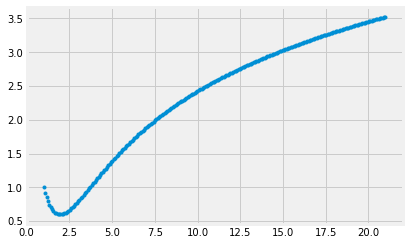

In [4]:
def func1(x, y):
    return np.log(x) - y**(np.e/np.pi)

def eulers_method(f, y_i, x_i, delta):
    y_i_plus_1 = y_i + delta*f(x_i, y_i)
    return y_i_plus_1


x_interval = (1, 20)
n_points = 250
y_0 = 1

x = np.linspace(x_interval[0], x_interval[1] + 1, n_points)
y = np.zeros([n_points])
y[0] = y_0

dx = x[1] - x[0]

for i in range(1, n_points):
    y[i] = eulers_method(func1, y[i-1], x[i-1], dx) 
    
plt.plot(x, y, '.')
plt.show()

## Harmonic Oscillators
While we specifically had a HW that discussed Quantum Harmonic Oscillators, Harmonic Oscillators in general are very applicable. 

Some applications of Harmonic Oscillators in ecology and biology are the "Lotka-Volterra model" equations.  These equations encompass are described as a predator prey model that will oscillate between predator-prey populations slowly increasing and then sharply decreasing.  These sorts of problems are also incredibly interesting to study from a stability analysis point of view and we could apply some of the ideas we learned in this class to this classification of problems quite easily.  An example of this type of oscillation is the following:

![Lotka-Volterra.png](Lotka-Volterra.png)


# Root Finding
Newton-Raphson was one of the first schemes we used to iteratively solve for an approach

# Other

Other methods we used both in class and in HW were for example shooting process where we used the bisection method to converge to some value while simultaneously solving our system of differential equations.  

![bisection example](bisection-book.png)


## Example Implementation

Below is an example implementation of the Newton-Raphson method along with the function that theoretically is doing the same thing from numpy.  We obtain approximately the same result, so we can probably assume the rest of numpy and scipy work exactly as expected as well!  Incredibly simple and allowed us to see how iterative approaches can be used to numerically solve problems that may be analytically impossible or tedious.  

In [5]:
def f1(x):
    return -x**2 + 5

sol = newton(f1, 1.0)

def our_newton_raphson(x):
    return x - (-x**2 + 5)/(-2*x)

xn = [1.0]
for _ in range(50):
    if f1(xn[-1]) < 10^-10:
        break
    xn.append(our_newton_raphson(xn[-1]))

print(f'Root found with scipy method is:       {sol}')
print(f'Root found with our implementation is: {xn[-1]}')

Root found with scipy method is:       2.236067977499817
Root found with our implementation is: 2.23606797749979


---

# Fourier Transforms

Fourier Transforms were another very cool and useful tool we learned how to use in this class.   They allow us to take problems and equations that may be hard to solve and transform them into a space that is easier to solve the problem in.  From there, we can solve the problem and then take the solution back into a real or complex space.  This is really cool!  There's also many other spectral methods and while we covered just two, they allowed us to solve the Reaction Diffusion Equations.

## Code Example

Below I have some code from the homework where we used the equation for the time evolution of some vorticity points.  The code shows a variety of aspects covered in the course such as creating a 5 point stencil of the Laplacian and various other derivatives that we use to solve the problems

In [6]:
# Using these to store params and pass around vals rather than dict

class MatrixParameters(SimpleNamespace):
    """docstring for Params"""

    def __init__(self, L=10, n=64, nu=0.001, tspan=(0,4), tstepsize=0.5):
        self.L = L
        self.n = n
        self.nn = n * n
        self.nu = nu
        self.tstepsize = tstepsize
        self.tspan = tspan
        self.t_eval = np.arange(tspan[0], tspan[1] + tstepsize, tstepsize)
        # create xyspan with periodic conditions™
        self.xyspan = np.linspace(-self.L, self.L, self.n + 1)[0:-1]
        self.dx = self.xyspan[1] - self.xyspan[0]


class ImageParameters(SimpleNamespace):
    def __init__(self, title='default', format_='gif', cmap='twilight'):
        self.title = title
        self.format_ = format_

        if self.format_ == 'gif':
            self.writer = 'imagemagick'

        self.filename = f'{self.title}.{self.format_}'
        self.cmap = cmap


defaultP = MatrixParameters()
defaultImageP = ImageParameters()


def create_vorticity_matrix(xyspan,
                            x0y0=[0, 0],
                            xbump=1.0,
                            ybump=1.0,
                            charge=1.0,
                            strength=1.0):
    X, Y = np.meshgrid(xyspan, xyspan)
    Xpart = (((X - x0y0[0]) ** 2) / xbump)
    Ypart = (((Y - x0y0[1]) ** 2) / ybump)
    vorticity_vals = - Xpart - Ypart
    # vorticity_vals = - (((X - x0y0[0]) ** 2) / xbump) - \
    # (((Y - x0y0[1]) ** 2) / ybump)
    omega = charge * strength * np.exp(vorticity_vals)
    return omega


def get_vorticity(params=defaultP, opts=None):
    omega_0 = create_vorticity_matrix(params.xyspan, ybump=20)
    return omega_0.reshape(-1, order='F')


def create_A(n, dx, A_11=2, diagonal_constant=-4):
    nn = n * n
    dd = diagonal_constant * np.ones(nn)
    e1 = np.ones(nn)

    A_d = spdiags(dd, [0], nn, nn)

    A_x_diags = [-((n - 1) * n), -n, n, ((n - 1) * n)]
    A_x = spdiags([e1, e1, e1, e1], A_x_diags, nn, nn)

    A_y = spdiags([e1, e1], [-1, 1], nn, nn)
    # need this to iterate through
    A_y = A_y.tolil()

    for j in range(0, n - 1):
        A_y[n * j, (j + 1) * n - 1] = 1
        A_y[(j + 1) * n - 1, n * j] = 1
        A_y[(j + 1) * n, (j + 1) * n - 1] = 0
        A_y[(j + 1) * n - 1, (j + 1) * n] = 0

    A_y[nn - 1, -n] = 1
    A_y[nn - n, -1] = 1

    A = A_d + A_x + A_y
    A[0, 0] = A_11

    A = A / (dx**2)
    return A.tocsc()


def create_B(n, dx):
    nn = n ** 2
    e1 = np.ones(nn)
    B_diags = [-(n * (n - 1)), -n, n, (n * (n - 1))]

    B = spdiags([e1, -e1, e1, -e1], B_diags, nn, nn)
    B = B / (2 * dx)
    return B.tocsc()


def create_C(n, dx):
    nn = n ** 2
    e1 = np.ones(nn)
    C = spdiags([-e1, e1], [-1, 1], nn, nn)
    C = C.tolil()

    for j in range(0, n - 1):
        C[n * j, (j + 1) * n - 1] = -1
        C[(j + 1) * n - 1, n * j] = 1
        C[(j + 1) * n, (j + 1) * n - 1] = 0
        C[(j + 1) * n - 1, (j + 1) * n] = 0

    C[nn - 1, -n] = 1
    C[nn - n, -1] = 1
    C = C / (2 * dx)
    return C.tocsc()


# adding this to dict of matrices although its only necessary for fft
def fft_create_laplacian(params=defaultP):
    L_fft = params.L * 2
    kx = (2 * np.pi/L_fft) * np.array(list(range(0, int(params.n/2))) + list(range(int(-params.n/2),-1+1))) 
    kx[0] = 10**-6
    ky = kx
    KX, KY = np.meshgrid(kx, ky)
    K = np.square(KX) + np.square(KY)
    return K


def create_matrices(n, dx):
    A = create_A(n, dx)
    B = create_B(n, dx)
    C = create_C(n, dx)
    K = fft_create_laplacian()

    return {'A': A, 'B': B, 'C': C, 'K': K}

## Using FFT or LU

Below we show how you would use various methods such as LU or FFT to solve for our $\psi$ within the ode45/solve_ivp functions.

In [7]:
def lu_method(omega_t, matrix, params):
    lu = linalg.splu(matrix['A'])
    psi = lu.solve(omega_t)
    
    return psi

def fft_method(omega_t, matrix, params):
    omega_fft = np.reshape(omega_t, (params.n, params.n), order='F')
    omega_fft = np.fft.fft2(omega_fft)
    psi_fft = np.divide(-omega_fft, matrix['K'])
    psi = np.real(np.fft.ifft2(psi_fft))
    psi = np.reshape(psi, -1, order='F')
    return psi
    
psi_solving_methods = {
    'lu': lu_method,
    'fft': fft_method
}

def rhs(t, omega_t, matrix, psi_method, params=defaultP):
    """
    rhs to use for ode45/solve_ivp equation

    """
    
    psi = psi_solving_methods[psi_method](omega_t, matrix, params)

    dwdt = ((-matrix['B'] @ psi) * (matrix['C'] @ omega_t)) + \
        ((matrix['C'] @ psi) * (matrix['B'] * omega_t)) + \
        (params.nu * matrix['A'] * omega_t)
    return dwdt


def solve_for_omega(omega_col, matrix, params=defaultP, psi_method='lu'):
    soln = solve_ivp(lambda t, y: rhs(t, y, matrix, psi_method, params),
                     params.tspan, omega_col, t_eval=params.t_eval,
                     vectorized=False)
    return soln

def plot_k(soln, params=defaultP, k=0):
    y = soln.y.T[k].reshape([params.n, params.n], order='F')
    plt.imshow(y)
    plt.show()

def create_simple_image_for_soln(soln,
                                 image_params=defaultImageP,
                                 params=defaultP):

    fig, ax = plt.subplots(1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    if image_params.title:
        ax.set_title(image_params.title, loc='right')

    data = []
    for k in soln.y.T:
        data.append(k.reshape(params.n, params.n, order='F'))

    ims = []
    for i in data:
        # im = plt.pcolormesh(i)
        im = plt.pcolormesh(i, cmap=image_params.cmap, shading='gouraud')
        ims.append([im])

    ani = animation.ArtistAnimation(
        fig, ims, interval=50, blit=True, repeat_delay=200)

    if image_params.format_ == 'gif':
        ani.save(image_params.filename, writer='imagemagick')
    else:
        ani.save(image_params.filename)

    plt.close(fig)


def random_point(l):
    x0 = random.randint(-l, l)
    y0 = random.randint(-l, l)
    return (x0, y0)


def random_charge(s=[-1, 1]):
    return random.choice(s)

def two_opposite_charged(matrix, params=defaultP):
    """
        Two oppositely “charged” Gaussian vortices next to each other,
        i.e. one with positive amplitude, the other with negative amplitude.
    """

    point1 = create_vorticity_matrix(
        params.xyspan, x0y0=(-1, 0), ybump=10, charge=1.0)

    point2 = create_vorticity_matrix(
        params.xyspan, x0y0=(1, 0), ybump=10, charge=-1.0)

    omega_0 = point1 + point2
    omega_0 = omega_0.reshape(-1, order='F')

    soln = solve_for_omega(omega_0, matrix)

    image_params = ImageParameters(title='two "opposite" charged')

    create_simple_image_for_soln(soln, image_params)

In [8]:
params = MatrixParameters()
matrix = create_matrices(n=params.n, dx=params.dx)

omega_0 = create_vorticity_matrix(params.xyspan, x0y0=(-1, 0), ybump=10, charge=1.0)
omega_0 = omega_0.reshape(-1, order='F')

soln = solve_for_omega(omega_0, matrix, psi_method="lu")

```python
import timeit

print('time for 10 fft: ', timeit.timeit('solve_for_omega(omega_0, matrix, psi_method="fft")', number=10, globals=globals()))
print('time for 10 lu: ', timeit.timeit('solve_for_omega(omega_0, matrix, psi_method="lu")', number=10, globals=globals()))
```

```bash
time for 10 fft:  4.046031098
time for 10 lu:  4.096500378999999
```

This allowed us to create very cool graphs and images such as the following:

![2 vorticity gif](vorticity.gif)

---
# Finite Elements

The last topic we covered in class was how we would use finite elements to solve PDE's.   This is one area where Matlab seems much better to solve problems.  The tols from pdepe and pdetoolbox allowed us to discreatize and solve PDE's in ways that are not quite as simple in python.  The pdetool seems incredibly powerful and while the example we did in class was quite funny, it is easy to see how it can be used to solve very abstract and difficult problems that play out in real problems related to heat equations on real life surfaces.  The toolbox allows for the solution of elliptic, eigenvalue parabolic and hyperbolic type problems along with Dirichlet and Neumann boundary conditions.  See below for another image created in pdetool inspired by Professor Eli's image.

![pdetool](pdetool-image.png)

----

# Application On Additional Problem From The End

The three-body problem from the back of the book was a really interesting example of how you would model a three celestial bodies where 2 of them would be fixed.  There are some other constraints and info about the bodies such as $m1, m2 \gg m3 $ and various other tid bits.  While the equations given in the back of differ from other derivations I found, I chose to stick with them as they would more easily resemble known results from the book.  

One of the neat things I found about some of the other derivations were they would allow you to incorporate more moving masses along with allowing one of the fixed masses to be influenced by the other as well.  These equations become quickly quite more complicated and the assumptions made for the equations such as gravitational constant incorporated into $\mu$ make it not feasible to incorporate.  Another interesting idea I thought would be possible is given some orbit of a celestial body (say for example _**mars**_) and its known path, you would be able to calculate the initial velocity needed (given the initial position would be the same as some celestial body say _**earth**_ which would incorporate angle of take off) to arrive at some other body (again maybe for example _**mars**_) with a method like what we learned in class such as fast fourier transform since we would know the start and end points and the force pulling it between those points and inverse fft to get the velocity and angles needed.  While that's probably quite more extensive than I would be able to manage for this final project the idea seems plausible and upon investigation there are tons of historic and current applications of Fast Fourier Transforms to solve various problems.  

For reference:

- [Spectral Analysis of Orbits via Discrete Fourier Transforms](https://www.math.fsu.edu/~aluffi/archive/paper154.pdf)
- [Fast Fourier Transforms History and Seminar Slides](http://web.math.ucsb.edu/~siam/2014-Fall/smith_fft.pdf)

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d


dx = lambda u: u
dy = lambda v: v
dz = lambda w: w

def du(x, y, z, u, v, mu):
    """allow all variables so can pass in as dict"""
    first_frac = (mu*(-1 + x + mu))/np.power(np.sqrt((np.square(y) + np.square(z) + np.square(-1 + x + mu))), 3)
    second_frac = ((1 - mu)*(x + mu))/np.power(np.sqrt((np.square(y) + np.square(z) + np.square(x + mu))), 3)
                  
    du_ = 2*v + x - first_frac - second_frac
    return du_
    
def dv(x, y, z, u, v, mu):
    """allow all variables so can pass in as dict"""
    
    first_frac = (mu*y)/np.power(np.sqrt((np.square(y) + np.square(z) + np.square(-1 + x + mu))), 3)
    second_frac = ((1 - mu)*y)/np.power(np.sqrt((np.square(y) + np.square(z) + np.square(x + mu))), 3)
                  
    dv_ = -2*u + y - first_frac - second_frac
    return dv_

def dw(x, y, z, u, v, mu):
    """allow all variables so can pass in as dict"""
    
    first_frac = (mu*z)/np.power(np.sqrt((np.square(y) + np.square(z) + np.square(-1 + x + mu))), 3)
    second_frac = ((1 - mu)*z)/np.power(np.sqrt((np.square(y) + np.square(z) + np.square(x + mu))), 3)
                  
    dw_ = -first_frac - second_frac
    return dw_

def update_position_vector(t, y0, mu):
    mu = 0.1
    x, y, z, u, v, w = y0
    
    dx_ = dx(u)
    dy_ = dy(v)
    dz_ = dz(w)
    
    du_ = du(x, y, z, u, v, mu)
    dv_ = dv(x, y, z, u, v, mu)
    dw_ = dw(x, y, z, u, v, mu)
    
    return [dx_, dy_, dz_, du_, dv_, dw_]
    
    
def simulate_3body(ip=(-1.2, 0, 0), iv=(0, 0, 0), mu=0.1, tspan=[0, 12], n_points=100):
    ic = ip + iv
    soln = solve_ivp(lambda t, y: update_position_vector(t, y, mu), 
                     tspan, y0=ic, t_eval=np.linspace(tspan[0], tspan[1], n_points)) 
    return soln


def create_plot_3body(soln, save_image=False, image_name=None):
    m1 = (0, 0, 0)
    m2 = (-1, 0, 0)
    
    fig = plt.figure(figsize=(10, 8))
    ax = Axes3D(fig)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])


    # position vector
    ax.plot(soln.y[0],soln.y[1], soln.y[2], label='path of m3')
    ax.legend()

    ax.set_title('initial position (ip) to final position (fp)')
    ax.text(soln.y[0][-1], soln.y[1][-1], soln.y[2][-1], "final", color="black", fontsize=14)
    ax.scatter3D(soln.y[0][-1], soln.y[1][-1], soln.y[2][-1], color='black')
    
    # m1 text and point
    ax.scatter3D(m1[0], m1[1], m1[2], color='r')
    ax.text(m1[0], m1[1], m1[2], "m1", fontsize=15, color='r')

    # m2 text and point
    ax.scatter(m2[0], m2[1], m2[2], color='m')
    ax.text(m2[0], m2[1], m2[2], "m2", fontsize=12, color='m')
    
    if save_image:
        fig.savefig(image_name)
    else:
        plt.show()


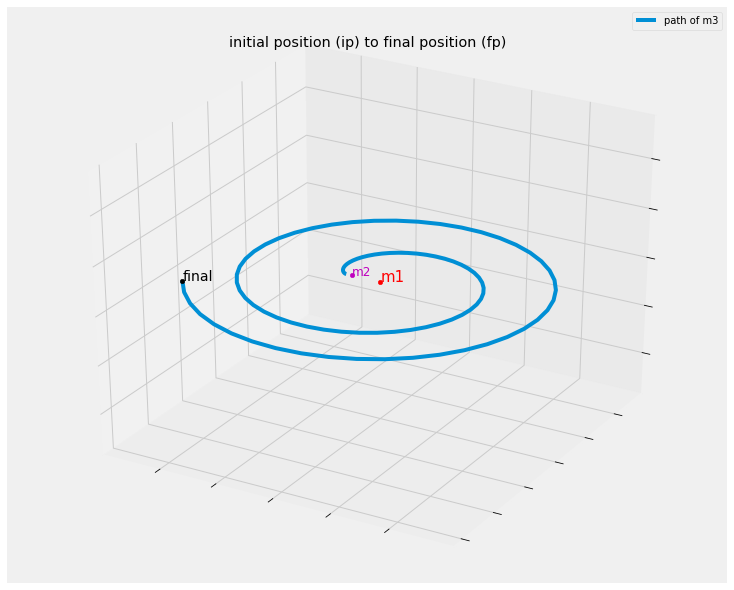

In [10]:
initial_position=(-1.2, 0.0, 0.0)
initial_velocity=(0.0, 0.0, 0.0)
tspan = [0, 15]

pos = simulate_3body(initial_position, initial_velocity, tspan=tspan)
create_plot_3body(pos)

# Inspection and Observations

One of the interesting things I noticed is that while the initial conditions given in the book are quite stable, although didn't seem as stable as the image in the book,
compare, my image with the same intial conditions given from the book followed by the books version of the trajectory::

![initial conditions from book](3-body-with-book-ic.png)

![results from book](3-body-book-image.png)

# ~Make it Cool~
While it was straightforward to apply what we learned in class to this problem, we can further animate the planet moving with a jupyter library called ipyvolume.  Install with 
```bash
pip install ipyvolume

jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install ipyvolume
jupyter labextension install jupyter-threejs
```

It seems pretty new and not super extensive but most matplotlib interactive/animations seem to not work or are very laggy with latest jupyter notebook/lab for me.


In [11]:
import ipyvolume as ipv

def create_3d_animation(pos):
    x, y, z = pos.y[0:3]

    
    x2 = []
    y2 = []

    for j in x:
        x2.append([j])
    for j in y:
        y2.append([j])

    x2 = np.array(x2)
    y2 = np.array(y2)

    ipv.figure()
    s = ipv.scatter(x2, y2, z, marker='sphere', color="black", size=2) 

    mxyz = np.array([0.0])
    m2x = np.array([-1.5])

    # add m1 and m2 mass
    ipv.scatter(mxyz, mxyz, mxyz, marker='sphere', color="magenta", size=5)
    ipv.scatter(m2x, mxyz, mxyz, marker='sphere', color="blue", size=3)
    # ipv.style.axes_off()
    ipv.style.box_off()
    ipv.xyzlim(2 * np.min(x)/3 , 2 * np.max(x)/3)
    ipv.animation_control(s, interval=200) # shows controls for animation controls ipv.show()
    ipv.show()
    return s

# interesting starting values, but try anything
initial_position=(-1.1, 0.000001, 0.000001)
initial_velocity=(0.0, 0.0, 0.0)
tspan = [0, 50]

pos = simulate_3body(initial_position, initial_velocity, tspan=tspan)
s = create_3d_animation(pos)

# Note

The above image can be moved with mouse and scrolled in to better see how our small m3 object is moving in various x, y, z planes.

In case the above jupyter widget doesn't work on your computer:

![gif-hard-to-tune-parameters](3body-animation.gif)

Thats it! Thanks and loved the class!

![Alt Text](https://media.giphy.com/media/vFKqnCdLPNOKc/giphy.gif)